In [24]:
#LIBRARIES
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pylab
import numpy as np
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
import itertools
import subprocess
import pandas as pd

#DATA
#data was recorded from t=0, but the experiment does not start until t=60
#there is also a 5-8s time lag between the start of the experiment and the measuring of heat in the ITC
#therefore, we disregard everything that comes before t=65
thr=65
DataCl=pd.read_excel('data/dataCl.xls')
DataCl=DataCl[DataCl.time>=thr].reset_index(drop=True)
DataS=pd.read_excel('data/dataS.xls')
DataS=DataS[DataS.time>=thr].reset_index(drop=True)
DataE=pd.read_excel('data/dataE.xls')
DataE=DataE[DataE.time>=thr].reset_index(drop=True)
DataE2=pd.read_excel('data/dataE2.xls')
DataE2=DataE2[DataE2.time>=thr].reset_index(drop=True)
DataR100=pd.read_excel('data/dataR100.xls')
DataR100=DataR100[DataR100.time>=thr].reset_index(drop=True)
DataR400=pd.read_excel('data/dataR400.xls')
DataR400=DataR400[DataR400.time>=thr].reset_index(drop=True)

# FINDING OUT THE KINETIC CONSTANTS FOR OXA48

OXA48 is a beta-lactamase that shows biphasic kinetics in the presence of chloride, like these:

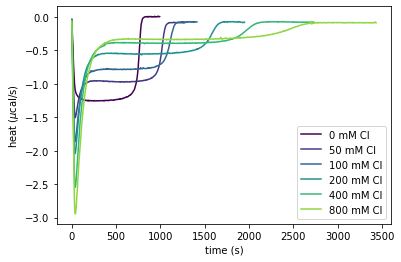

In [25]:
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
CL=[0,50,100,200,400,800]
for i,Cl in enumerate(CL):
    D=DataCl[Cl].dropna()
    ax.plot(D,color=cmap(i/len(CL)), label=str(Cl)+' mM Cl')
ax.set_xlabel('time (s)');
ax.set_ylabel('heat ($\mu$cal/s)');
ax.legend();

0 0.08740045906288296 2.5163999999999995 -0.00017499842463263994
50 0.031002797843630914 3.01296 0.00789071624832209
100 0.023350567159627095 3.73116 0.005635345025788406
200 0.008722974822057195 4.08842 0.0025025200195127983
400 0.0033268414763778335 5.09416 0.0013141353319127307
800 0.0033737466210104206 5.88946 0.0008447328087033629


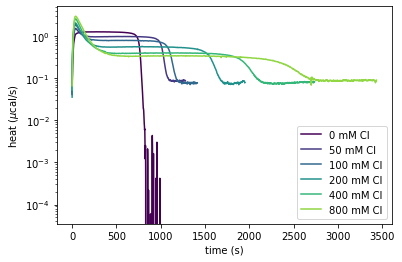

In [26]:
def getlow(D):
    xinit=0
    xend=xinit+30
    xp=range(xinit,xend)
    D1=D[xinit:xend]
    f=lambda x, *p: p[0]*x + p[1]
    popt, pcov = curve_fit(f,xp,np.log(D1),p0=[1,1])
    return -popt[0]

fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
CL=[0,50,100,200,400,800]
t1=[775,1020,1120,1550,1900,2500]
for i,Cl in enumerate(CL):
    D=DataCl[Cl].dropna()
    D2=D[t1[i]::]
    k1=getlow(-D2)
    k2=getk2(-D,5,0.1)
    k3=getk3(-D)
    n4=getk4(-D,k3)
    print(Cl,k1,k2,n4)
    ax.plot(-D,color=cmap(i/len(CL)), label=str(Cl)+' mM Cl')
ax.set_xlabel('time (s)');
ax.set_ylabel('heat ($\mu$cal/s)');
ax.legend();
ax.set_yscale('log');
#ax.set_xlim([1500,1800])

Our hypothesis is that, in addition to the usual enzymatic reactions, in the presence of chloride OXA48 undergoes an additional reaction from active enzyme-substrate complex to inactive one. 

The standard enzymatic reactions are as follows:
$$E+S \xrightarrow{k_1} C \xrightarrow{k_2} E+H,$$ 
where $E$ is enzyme, $S$ is substrate, $C$ is enzyme-substrate complex, and $H$ is heat released by the reaction. Although these reactions are actually reversible, in practice the kinetic constants are so skewed that we will consider them as irreversible for simplicity. 

In the presence of chloride OXA48 undergoes two additional reactions $C \xrightarrow{k_3} C_2$ and $C_2 \xrightarrow{k_4} C,$ to and from an inactive complex $C_2$ (see main text for more details).

Deriving the corresponding ordinary differential equations from the law of mass action (which is warranted since the number of molecules in the system is very high), we obtain the following system:
\begin{equation}
\begin{aligned}
\frac{dE}{dt} &= -k_1ES+k_2C,\\
\frac{dS}{dt} &= -k_1ES,\\
\frac{dC}{dt} &= k_1ES-k_2C-k_3C+k_4C_2,\\
\frac{dC_2}{dt} &= k_3C-k_4C_2,\\
\frac{dH}{dt} &= ck_2 C.
\end{aligned}
\end{equation}
Here $c$ is the conversion constant between moles of product and calories of heat. The variable that is measured experimentally is exactly $dH/dt$, and so our efforts will be directed towards finding $C(t)$.

In our experimental system, the substrate is pipetted into the ITC chamber (this takes around 20 seconds) and then it diffuses throughout the chamber. In other words, the enzyme does not encounter all of the substrate from the beginning of the experiment. A precise mathematical formulation of this problem would involve partial differential equations with diffusion which in principle could become somewhat complicated. As the aim of our model is to infer reasonable values for the kinetic constants, we have decided instead to 

$\Theta(t)$ is the Heaviside function that takes value $1$ if $t>0$ and $0$ otherwise, $E_0$ is the initial enzyme concenttrationand
\begin{equation}
\begin{aligned}
\frac{dE}{dt} &= \frac{E_0}{k_0}\big(1-\Theta(t-k_0)\big)-k_1ES+k_2C,\\
\frac{dS}{dt} &= -k_1ES,\\
\frac{dC}{dt} &= k_1ES-k_2C-k_3C+k_4C_2,\\
\frac{dC_2}{dt} &= k_3C-k_4C_2,\\
\frac{dH}{dt} &= ck_2 C.
\end{aligned}
\end{equation}

In [4]:
def set_k4(Cl):
    #Cv=[0.64,0.42,0.27,0.152,0.11]
    #CL=[50,100,200,400,800]
    #i=CL.index(Cl)
    #x=Cv[i]
    #print(x/(1-x), 0.72/Cl)
    # return x/(1-x)
    if Cl==0:
        return 1e8
    else:
        return 0.72/Cl

def set_k2(Cl):
    # Cv=[2.5164 , 3.01296, 3.73, 4.08842, 5.09416, 5.88946]
    # CL=[0,50,100,200,400,800]
    # i=CL.index(Cl)
    # x=Cv[i]
    return -4.62+1.55*np.log(Cl+98.23)

def oxa(t, y, Params):      
    #Variables
    E=y[0]#dimer
    S=y[1]#antibiotic
    C=y[2]#active complex
    C2=y[3]#inactive complex
    #Parameters
    Cl=Params.Cl
    E0=Params.E0
    k0=Params.k0
    k1=Params.k1
    k2=Params.k2
    k3=Params.k3*np.heaviside(t-Params.delay,0)
    k4=Params.k4
    k5=Params.k5
    #Equations
    dEdt=E0/k0*(1-np.heaviside(t-k0,1))-k1*E*S+k2*C+k5*C2
    dSdt=-k1*E*S
    dCdt=k1*E*S-k2*C-k3*C+k4*C2
    dC2dt=k3*C-k4*C2-k5*C2
    return [dEdt, dSdt, dCdt, dC2dt]

def oxa2(t, y, Params):      
    #Variables
    E=y[0]#dimer
    S=y[1]#antibiotic
    C=y[2]#active complex
    C2=y[3]#inactive complex
    #Parameters
    # Cl=Params.Cl
    Cl=100
    D=Params.Cl
    E0=Params.E0
    k0=Params.k0
    k1=Params.k1
    k2=Params.k2#*set_k2(Cl)#(-4.62+1.55*np.log(Cl+98.23))
    delay=43*D/(30+D)
    k3=Params.k3*np.heaviside(t-delay,0)#*delay
    k4=Params.k4
    #Equations
    dEdt=-k1*E*S+k2*C
    dEdt=E0/k0*(1-np.heaviside(t-k0,1))-k1*E*S+k2*C
    # dEdt=(2*E0/k0**2)*t*(1-np.heaviside(t-k0,1))-k1*E*S+k2*C
    # dSdt=S0/k0*(1-np.heaviside(t-k0,1))-k1*E*S
    dSdt=-k1*E*S
    dCdt=k1*E*S-k2*C-k3*C+k4*C2
    # dCdt=C0/k0*(1-np.heaviside(t-k0,1))+k1*E*S-k2*C-k3*C+k4*C2
    dC2dt=k3*C-k4*C2
    # dC2dt=C20/k0*(1-np.heaviside(t-k0,1))+k3*C-k4*C2
    return [dEdt, dSdt, dCdt, dC2dt]

def heat(c,k2,C,k5,C2):
    return c*k2*C+c*k5*C2

class Parameters:
    def __init__(self,p0,p1,p2,p3,p4,p5,Cl,E0,delay):
        self.k0=p0
        self.k1=p1
        self.k2=p2
        self.k3=p3
        self.k4=p4
        self.k5=p5
        self.Cl=Cl
        self.E0=E0
        self.delay=delay

In [23]:
def getc(D,S0):
    return D.sum()/S0

def getk2(D,c,E0):
    return D.max()/c/E0

def getk3(D):
    xinit=D.argmax()+10
    xend=xinit+30
    xp=range(xinit,xend)
    D1=D[xinit:xend]
    f=lambda x, *p: p[0]*x + p[1]
    popt, pcov = curve_fit(f,xp,np.log(D1),p0=[1,1])
    return -popt[0]

def getk4(D,k3):
    H=D[abs(D.diff())<1e-6][0:100]
    Hs=H.mean()
    Hmax=D.max()
    return k3*Hs/(Hmax-Hs)


# DIFFERENT CL CONCENTRATIONS

0 c 5 5
0 k2 2.490333084914507 2.5163999999999995
0 k3 0.009 -3.483072378923342e-05
0 k4 100000000.0 0.04521829150678189
L1 -100000000.0 -2.4903330877423286
L2 -2.490333084914507 -100000000.009
50 c 5 5
50 k2 3.1280859383649418 3.01296
50 k3 0.009 0.005765000930072523
50 k4 0.0144 0.012318548964051152
L1 -0.0144 -0.014358497818824256
L2 -3.1280859383649418 -3.1371274405461174
100 c 5 5
100 k2 3.578613357688286 3.73116
100 k3 0.009 0.008018853858842403
100 k4 0.0072 0.006324857158503857
L1 -0.0072 -0.0071819016225294074
L2 -3.578613357688286 -3.5876314560657567
200 c 5 5
200 k2 4.2116907513828545 4.08842
200 k3 0.009 0.00924685170554062
200 k4 0.0036 0.0024357133533481263
L1 -0.0036 -0.003592316992238942
L2 -4.2116907513828545 -4.2206984343906155
400 c 5 5
400 k2 5.007145817583074 5.09416
400 k3 0.009 0.009538998667085172
400 k4 0.0018 0.0012398804528639916
L1 -0.0018 -0.0017967692715759043
L2 -5.007145817583074 -5.016149048311498
800 c 5 5
800 k2 5.920660548355673 5.88946
800 k3 0.009 

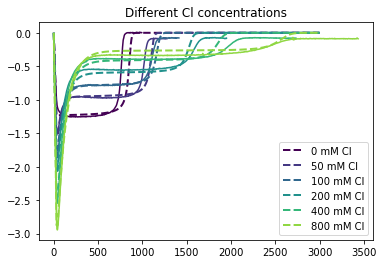

In [22]:
#SIMULATE CL DATA
E0=100e-3
S0=200
CL=[0,50,100,200,400,800]

k0=30
k1=1
k2=1
k3=0.009#89
delay=45
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
fig=plt.figure()
K=[5,0.5,0.05,0.005]
for j,k5 in enumerate(K5):
    ax=fig.add_subplot(2,2,j+1)
    for i,Cl in enumerate(CL):
        D=DataCl[Cl].dropna()
        k2=set_k2(Cl)
        c=getc(-D,S0)
        n2=getk2(-D,c,E0)
        n3=getk3(-D)
        k4=set_k4(Cl)
        n4=getk4(-D,k3)
        ParamV=[k0,k1,n2,k3,k4,k5]
        Params=Parameters(*ParamV,Cl,E0,delay)
        tf=3000
        y0=[0,S0,0,0]
        sol=solve_ivp(oxa,(0,tf),y0,method='Radau',t_eval=range(tf),args=((Params,)))
        T=sol.t
        E=sol.y[0,:]
        S=sol.y[1,:]
        C=sol.y[2,:]
        C2=sol.y[3,:]
        H=heat(c,k2,C,k5,C2)
        ax.plot(T,-H,'--',lw=2,color=cmap(i/len(CL)), label=str(CL[i])+' mM Cl')
        ax.plot(D,color=cmap(i/len(CL)))
    ax.set_title('$k_5=$'+str(k5))
ax.legend()
fig.savefig('figures/suppfig_inactive_hydrolisisimCl_prueba.pdf', bbox_inches='tight')

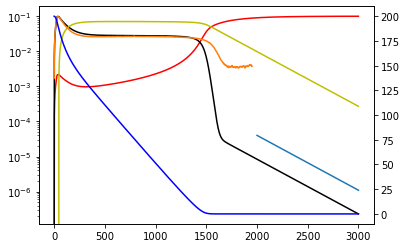

In [85]:
#SIMULATE CL DATA
E0=100e-3
S0=200

k0=30
k1=1
k2=4.2
k3=0.009
k4=0.0036
delay=45
ParamV=[k0,k1,k2,k3,k4]
Params=Parameters(*ParamV,200,E0,delay)
tf=3000
y0=[0,S0,0,0]
sol=solve_ivp(oxa,(0,tf),y0,method='Radau',t_eval=range(tf),args=((Params,)))
T=sol.t
E=sol.y[0,:]
S=sol.y[1,:]
C=sol.y[2,:]
C2=sol.y[3,:]
H=heat(C,c,k2)

fig=plt.figure()
ax=plt.gca()
ax2=ax.twinx()
ax.plot(T,E,'r')
ax2.plot(T,S,'b')
ax.plot(T,C,'k')
ax.plot(T,C2,'y')
ax.set_yscale('log')
xp=np.linspace(2000,3000,1000)
yp=4e-5*np.exp(-k4*t)
ax.plot(xp,yp)
D=DataCl[200].dropna()
ax.plot(-D/5/k2)

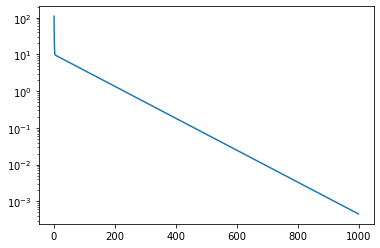

In [86]:
c1=100
c2=10
k2=2
k4=0.01
t=np.linspace(0,1000,1000)
yp=c1*np.exp(-k2*t)+c2*np.exp(-k4*t)
fig=plt.figure()
ax=plt.gca()
ax.plot(yp)
ax.set_yscale('log')

# DIFFERENT S CONCENTRATIONS

50 k2 3.4169799999999997
50 k3 0.008
50 k4 0.005
100 k2 3.8112
100 k3 0.008
100 k4 0.005
200 k2 3.76706
200 k3 0.008
200 k4 0.005
400 k2 4.0616
400 k3 0.008
400 k4 0.005
600 k2 4.23468
600 k3 0.008
600 k4 0.005
800 k2 4.39614
800 k3 0.008
800 k4 0.005


Text(0.5, 1.0, 'Different S concentrations')

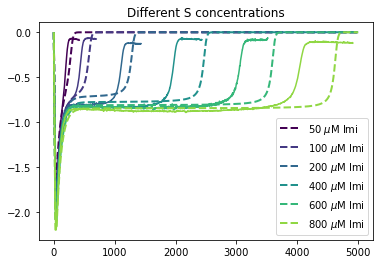

In [49]:
#SIMULATE S DATA
E0=100e-3
Cl=100
ST=[50,100,200,400,600,800]
delay=45
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
for i,S0 in enumerate(ST):
    D=DataS[S0].dropna()
    k0=25
    k1=1
    c=5
    k2=getk2(-D,c,E0)
    print(S0,'k2',k2)
    k3=getk3(-D)
    k3=0.008
    print(S0,'k3',k3)
    k4=getk4(-D,k3)
    k4=0.005
    print(S0,'k4',k4)
    ParamV=[k0,k1,k2,k3,k4]
    Params=Parameters(*ParamV,Cl,E0,delay)
    tf=5000
    y0=[0,S0,0,0]
    sol=solve_ivp(oxa,(0,tf),y0,method='Radau',t_eval=range(tf),args=((Params,)))
    T=sol.t
    E=sol.y[0,:]
    S=sol.y[1,:]
    C=sol.y[2,:]
    C2=sol.y[3,:]
    H=heat(C,c,k2)
    ax.plot(T,-H,'--',lw=2,color=cmap(i/len(ST)), label=str(ST[i])+' $\mu$M Imi')
    ax.plot(D,color=cmap(i/len(ST)))
ax.legend()
ax.set_title('Different S concentrations')
#ax.set_xlim([0,200])

# DIFFERENT E CONCENTRATIONS (1)

10.0 k2 4.002400000000001
10.0 k3 0.006152299926714955
10.0 k4 0.004
50.0 k2 4.00028
50.0 k3 0.006309350777424718
50.0 k4 0.004
100.0 k2 4.25368
100.0 k3 0.007144186128065872
100.0 k4 0.004
150.0 k2 4.015066666666667
150.0 k3 0.007020951167177056
150.0 k4 0.004
200.0 k2 4.178499999999999
200.0 k3 0.007013379709235323
200.0 k4 0.004
400.0 k2 4.228509999999999
400.0 k3 0.008138160559712615
400.0 k4 0.004


Text(0.5, 1.0, 'Different E concentrations (1)')

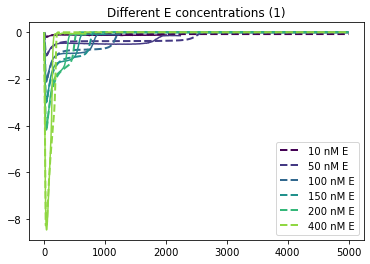

In [34]:
#SIMULATE E DATA
S0=200
Cl=100
ET=[10,50,100,150,200,400]
delay=45
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
for i,E0 in enumerate(ET):
    D=DataE[E0].dropna()
    E0/=1000
    k0=25
    k1=1
    c=5
    k2=getk2(-D,c,E0)
    print(E0*1e3,'k2',k2)
    k3=getk3(-D)
    print(E0*1e3,'k3',k3)
    k4=getk4(-D,k3)
    k4=0.004
    print(E0*1e3,'k4',k4)
    ParamV=[k0,k1,k2,k3,k4]
    Params=Parameters(*ParamV,Cl,E0,delay)
    tf=5000
    y0=[0,S0,0,0]
    sol=solve_ivp(oxa,(0,tf),y0,method='Radau',t_eval=range(tf),args=((Params,)))
    T=sol.t
    E=sol.y[0,:]
    S=sol.y[1,:]
    C=sol.y[2,:]
    C2=sol.y[3,:]
    H=heat(C,c,k2)
    ax.plot(T,-H,'--',lw=2,color=cmap(i/len(ET)), label=str(ET[i])+' nM E')
    ax.plot(D,color=cmap(i/len(ET)))
ax.legend()
ax.set_title('Different E concentrations (1)')
#ax.set_xlim([0,1000])

# DIFFERENT E CONCENTRATIONS (2)

10.0 k2 3.4597499999999997
10.0 k3 0.008915101601559172
10.0 k4 0.004
50.0 k2 3.22728
50.0 k3 0.006961049699660826
50.0 k4 0.004
100.0 k2 3.5283469999999997
100.0 k3 0.008455614209507419
100.0 k4 0.004
200.0 k2 3.0142875
200.0 k3 0.00863953173611464
200.0 k4 0.004
400.0 k2 3.09491175
400.0 k3 0.008460764541278348
400.0 k4 0.004
600.0 k2 2.9982785
600.0 k3 0.008603405451004686
600.0 k4 0.004


Text(0.5, 1.0, 'Different E concentrations (2)')

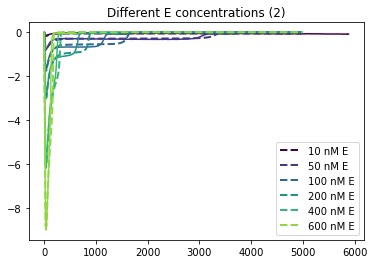

In [36]:
#SIMULATE E DATA
S0=200
Cl=100
ET=[10,50,100,200,400,600]
delay=45
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
for i,E0 in enumerate(ET):
    D=DataE2[E0].dropna()
    E0/=1000
    k0=25
    k1=1
    c=5
    k2=getk2(-D,c,E0)
    print(E0*1e3,'k2',k2)
    k3=getk3(-D)
    print(E0*1e3,'k3',k3)
    k4=getk4(-D,k3)
    k4=0.004
    print(E0*1e3,'k4',k4)
    ParamV=[k0,k1,k2,k3,k4]
    Params=Parameters(*ParamV,Cl,E0,delay)
    tf=5000
    y0=[0,S0,0,0]
    sol=solve_ivp(oxa,(0,tf),y0,method='Radau',t_eval=range(tf),args=((Params,)))
    T=sol.t
    E=sol.y[0,:]
    S=sol.y[1,:]
    C=sol.y[2,:]
    C2=sol.y[3,:]
    H=heat(C,c,k2)
    ax.plot(T,-H,'--',lw=2,color=cmap(i/len(ET)), label=str(ET[i])+' nM E')
    ax.plot(D,color=cmap(i/len(ET)))
ax.legend()
ax.set_title('Different E concentrations (2)')
#ax.set_xlim([0,1000])

# REACTIVATION AT 100mM CL 

700
749
799
847
897
997
1097
1197
1295


Text(0.5, 1.0, 'Reactivation 100 mM Cl')

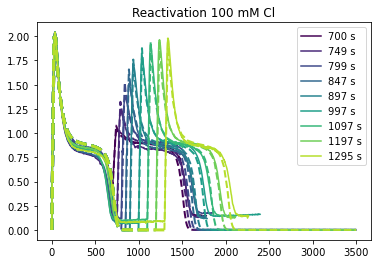

In [37]:
E0=100e-3
S0=140
TR=[765, 814, 864, 912, 962, 1062, 1162, 1262, 1360]
Cl=100
Cv=0.42
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
K4=[]
for i,tf in enumerate(TR):
    D=DataR100[tf].dropna()
    tf=tf-thr
    print(tf)
    k0=25
    k1=1
    k2=4.1
    k3=0.0089
    E0=100e-3
    S0=140
    c=5
    ParamV=[k0,k1,k2,k3]
    p4=ParamV[3]*set_k4(Cl)
    p4=set_k4(Cl)
    Params=Parameters(*ParamV,p4,Cl,E0,delay)
    y0=[0,S0,0,0]
    sol=solve_ivp(oxa,(0,tf),y0,method='Radau',t_eval=range(tf),args=((Params,)))
    T=sol.t
    E=sol.y[0,:]
    S=sol.y[1,:]
    C=sol.y[2,:]
    C2=sol.y[3,:]
    H=heat(C,c,k2)
    ax.plot(T,H,'--',lw=3,color=cmap(i/len(TR)))
    y0=[E[-1],0,C[-1],C2[-1]]
    k0=40
    # k2=1
    S0=140
    ParamV=[k0,k1,k2,k3]
    Params=Parameters(*ParamV,p4,tf-700,E[-1],delay)
    y0=[0,S0,C[-1],C2[-1]]
    sol=solve_ivp(oxa2,(0,3500-tf),y0,method='Radau',args=((Params,)))
    T=sol.t+tf
    E=sol.y[0,:]
    S=sol.y[1,:]
    C=sol.y[2,:]
    C2=sol.y[3,:]
    H=heat(C,c,k2)
    ax.plot(-D,color=cmap(i/len(TR)), label=str(tf)+' s')
    ax.plot(T,H,'--',lw=2,color=cmap(i/len(TR)))
ax.legend()
ax.set_title('Reactivation 100 mM Cl')
#ax.set_xlim([500,1500])
#ax.set_xlim([0,100])

# REACTIVATION AT 400mM CL 

890
997
1094
1196
1400
1599
1795
1996
2200
2397
2601


Text(0.5, 1.0, 'Reactivation 400 mM Cl')

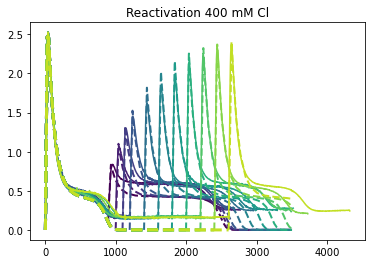

In [38]:
k2=0.5
k3=0.0089
E0=100e-3
S0=140
Cv=[0.64,0.42,0.27,0.152,0.11]
TR=[955, 1062, 1159, 1261, 1465, 1664, 1860, 2061, 2265, 2462, 2666]
Cl=400
Cv=0.152
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
K4=[]
for i,tf in enumerate(TR):
    D=DataR400[tf].dropna()
    tf=tf-thr
    print(tf)
    k0=25
    k1=1
    k2=5.15
    k3=0.0089
    E0=100e-3
    S0=120
    c=5
    ParamV=[k0,k1,k2,k3]
    p4=ParamV[3]*set_k4(Cl)
    p4=set_k4(Cl)
    Params=Parameters(*ParamV,p4,Cl,E0,delay)
    y0=[0,S0,0,0]
    sol=solve_ivp(oxa,(0,tf),y0,method='Radau',t_eval=range(tf),args=((Params,)))
    T=sol.t
    E=sol.y[0,:]
    S=sol.y[1,:]
    C=sol.y[2,:]
    C2=sol.y[3,:]
    H=heat(C,c,k2)
    ax.plot(T,H,'--',lw=3,color=cmap(i/len(TR)))
    y0=[E[-1],0,C[-1],C2[-1]]
    k0=40
    # k2=1
    S0=140
    ParamV=[k0,k1,k2,k3]
    Params=Parameters(*ParamV,p4,tf-700,E[-1],delay)
    y0=[0,S0,C[-1],C2[-1]]
    sol=solve_ivp(oxa2,(0,3500-tf),y0,method='Radau',args=((Params,)))
    T=sol.t+tf
    E=sol.y[0,:]
    S=sol.y[1,:]
    C=sol.y[2,:]
    C2=sol.y[3,:]
    H=heat(C,c,k2)
    ax.plot(-D,color=cmap(i/len(TR)), label=str(tf)+' s')
    ax.plot(T,H,'--',lw=2,color=cmap(i/len(TR)))
ax.set_title('Reactivation 400 mM Cl')
#ax.legend()
#ax.set_xlim([500,1500])
#ax.set_xlim([0,100])